# Airbnb Seattle Data Analysis
By: Satrio Putra

Finding place to spend the night is easy nowaday using online app such as Airbnb. Airbnb provides place for you to rent in various location in your destination. 

Here we got some data from Airbnb to analyze. After spend time looking at the data, we have some question to answer below:
- What is the vibe of each Seattle neighborhood from listing descriptions?
- What are the busiest times of the year to visit Seattle? By how much do prices spike?
- Is there a general upward trend of both new Airbnb listings and total Airbnb visitors to Seattle?
- What component affecting rent price?

#### Loading libraries
First, we need to import some required libraries.

In [21]:
# Importing libraries
import pandas as pd
import numpy as np
import re
import time
import matplotlib.pyplot as plt
import seaborn as sb

from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor

#### Defining Function

After the libraries have been loaded, we can define our own function below to process the data efficiently.

In [2]:
# Defining function here
def process_currency(df, column):
    """Removing '$', ',', and '.' sign from selected column
    and changing the data format to float.
    """
    df[column] = df[column].str.replace('$', '')
    df[column] = df[column].str.replace(',', '')
    df[column] = df[column].astype(float)

def fill_mode(df, column_list):
    """Filling nan with mode in selected column
    """
    for column in column_list:
        df[column].fillna(df[column].mode()[0], inplace=True)

def fill_mean(df, column_list):
    """Filling nan with mean in selected column
    """
    for column in column_list:
        df[column].fillna(df[column].mean(), inplace=True)
        
def evaluate_model(model, X_train, X_test, y_train, y_test):
    """Evaluate our trained model.    
    """
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    report_train = r2_score(y_train, y_train_pred)
    report_test = r2_score(y_test, y_test_pred)
    
    print('Train r2_score = {}'.format(report_train))
    print('Test r2_score = {}'.format(report_test))

#### Loading and Processing Datasets
Loading the data from Airbnb so we can see the data inside and find some insight about it. Data should be cleaned first and then we should extract information and visualize it through data plotting.

In [3]:
# Loading datasets
calendar_df = pd.read_csv('calendar.csv')
listing_df = pd.read_csv('listings.csv')
reviews_df = pd.read_csv('reviews.csv')

In [4]:
calendar_df.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [5]:
calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
 3   price       934542 non-null   object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


In [6]:
# Finding duplicate data
calendar_df.duplicated().sum()

0

In [7]:
# Processing calendar_df
calendar_df['date'] = pd.to_datetime(calendar_df['date'])
calendar_df['available'].replace(['t', 'f'], [True, False], inplace=True)

process_currency(calendar_df, 'price')
calendar_df = calendar_df.sort_values(by=['listing_id','date'])
calendar_df = calendar_df.fillna(method='ffill').fillna(method='bfill')

In [8]:
print('calender_df has data from {:%Y-%m-%d} to {:%Y-%m-%d} or'\
      'the data is recorded for {.days} days.'.format(calendar_df['date'].min(),
                                                      calendar_df['date'].max(),
                                                      calendar_df['date'].max()
                                                      - calendar_df['date'].min()))

calender_df has data from 2016-01-04 to 2017-01-02 orthe data is recorded for 364 days.


In [9]:
print('calender_df, listing_id column unique count: {}'
      .format(calendar_df['listing_id'].nunique()))

calender_df, listing_id column unique count: 3818


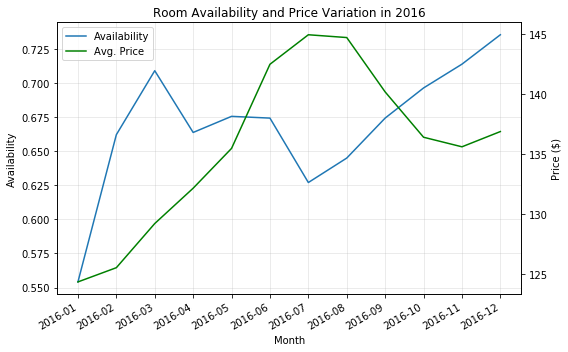

In [10]:
# Finding Room Availability and Price Variation in 2016
x1 = calendar_df.groupby(pd.Grouper(key='date',freq='M'))['available'].mean()[:12]
x2 = calendar_df.groupby(pd.Grouper(key='date',freq='M'))['price'].mean()[:12]
x = x1.index.values.astype('datetime64[M]').astype(str).tolist()

fig, ax1 = plt.subplots(figsize=(8,5))
ax1.plot(list(range(len(x1))), x1, label='Availability')

plt.xticks(list(range(len(x))), x, rotation=30, ha='right')
ax1.set_xlabel('Month')
ax1.set_ylabel('Availability')
ax1.set_title('Room Availability and Price Variation in 2016')
ax1.grid(alpha=0.3)

ax2 = ax1.twinx()
ax2.plot(list(range(len(x2))), x2, color='g', label='Avg. Price')
ax2.set_ylabel('Price ($)')
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')
plt.tight_layout();
# plt.savefig('Room Availability and Price Variation in 2016.png', dpi=1000);

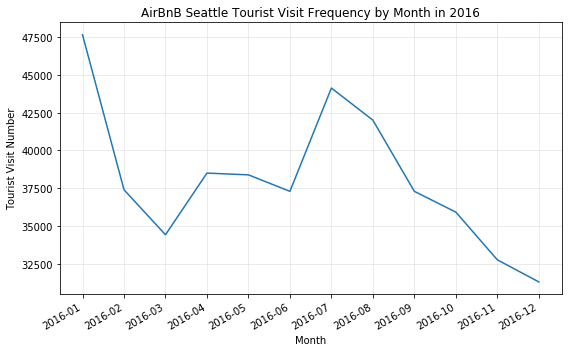

In [11]:
# Finding AirBnB Seattle Tourist Visit Frequency by Month in 2016
x1 = calendar_df.query('available == 0').groupby(pd.Grouper(key='date',freq='M'))['available'].count()[:12]
x2 = calendar_df.groupby(pd.Grouper(key='date',freq='M'))['price'].mean()[:12]
x = x1.index.values.astype('datetime64[M]').astype(str).tolist()

fig, ax1 = plt.subplots(figsize=(8,5))
ax1.plot(list(range(len(x1))), x1)

plt.xticks(list(range(len(x))), x, rotation=30, ha='right')
ax1.set_xlabel('Month')
ax1.set_ylabel('Tourist Visit Number')
ax1.set_title('AirBnB Seattle Tourist Visit Frequency by Month in 2016')
ax1.grid(alpha=0.3)

plt.tight_layout();
# plt.savefig('Tourist Visit Frequency by Month in 2016.png', dpi=1000);

##### Insight from calender dataset
We got some interesting finding from calendar dataset. From the first plot above, we can see that there was price hike on summer holiday in 2016. Average price were the highest on July 2016 while room availability was lower than before. This higher price could be because there was high demand of room. 

If we see data depicted on the second plot, number of tourist visiting Airbnb host is around 44,000 times, almost the same on early 2016 which was 47,000 times. But when we compared to the data on the first plot, availability on early 2016 is lower that mid year. This means there is significant increase in room number provided by the host. 

Meanwhile, there is decreasing trend in Airbnb user in Seattle in 2016. If there is recurring pattern, user number should be increasing in end year that it will be match with what the figure shown in early year, but the fact shows us the opposite.

In [12]:
reviews_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [13]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   listing_id     84849 non-null  int64 
 1   id             84849 non-null  int64 
 2   date           84849 non-null  object
 3   reviewer_id    84849 non-null  int64 
 4   reviewer_name  84849 non-null  object
 5   comments       84831 non-null  object
dtypes: int64(3), object(3)
memory usage: 3.9+ MB


In [14]:
reviews_df.duplicated().sum()

0

In [15]:
reviews_df['date'] = pd.to_datetime(reviews_df['date'])

In [16]:
print('reviews_df has data from {:%Y-%m-%d} to {:%Y-%m-%d} or'\
      'the data is recorded for {.days} days.'.format(reviews_df['date'].min(),
                                                      reviews_df['date'].max(),
                                                      reviews_df['date'].max()
                                                      - reviews_df['date'].min()))

reviews_df has data from 2009-06-07 to 2016-01-03 orthe data is recorded for 2401 days.


In [17]:
listing_df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [18]:
listing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

Queen Anne


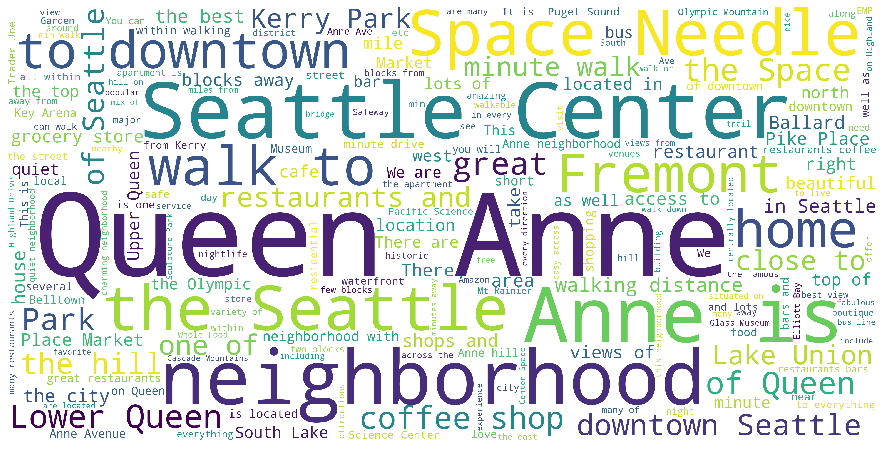

Ballard


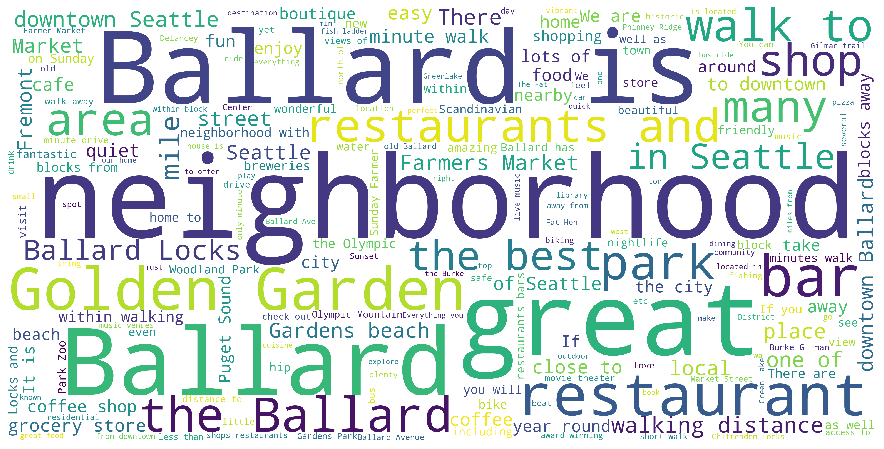

Other neighborhoods


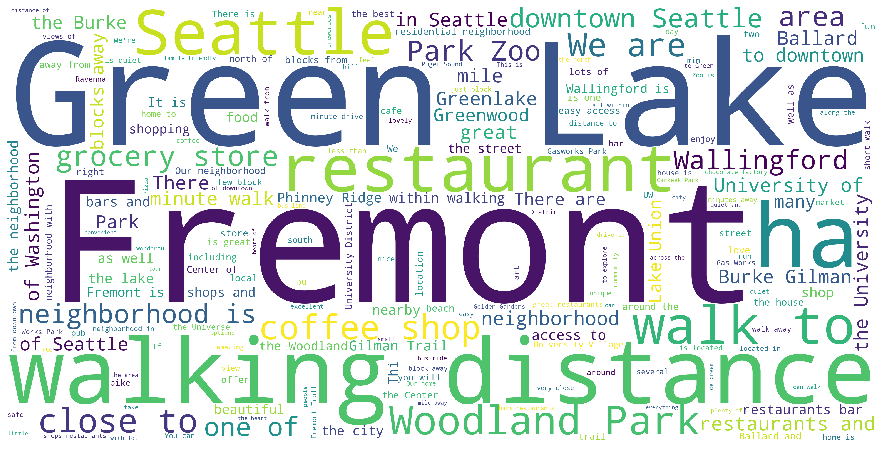

Cascade


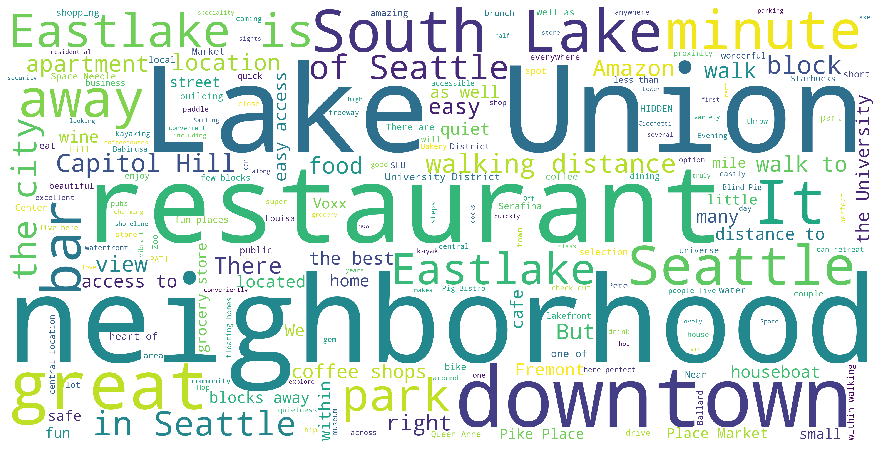

Central Area


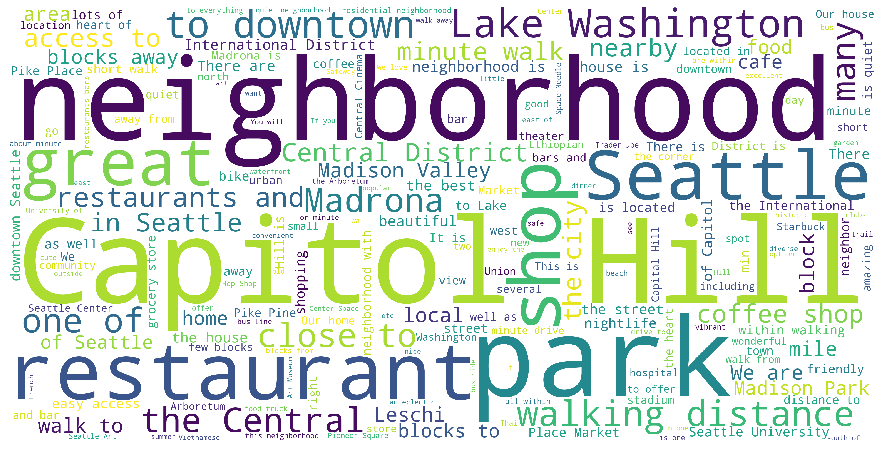

University District


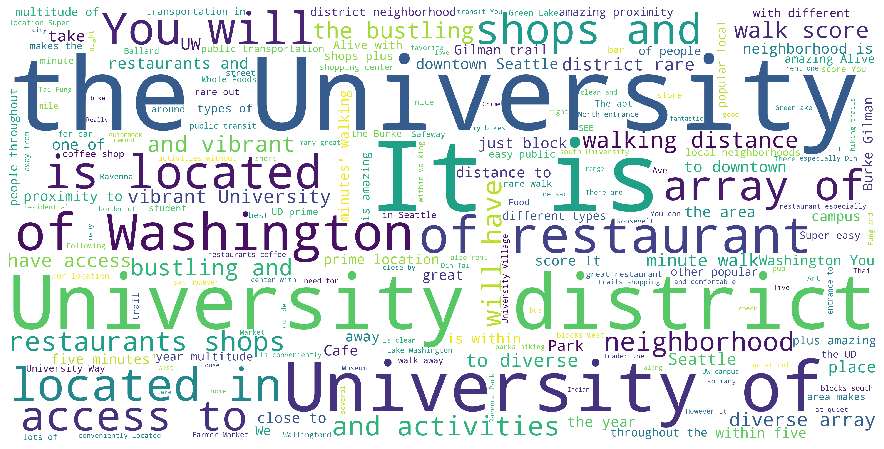

Downtown


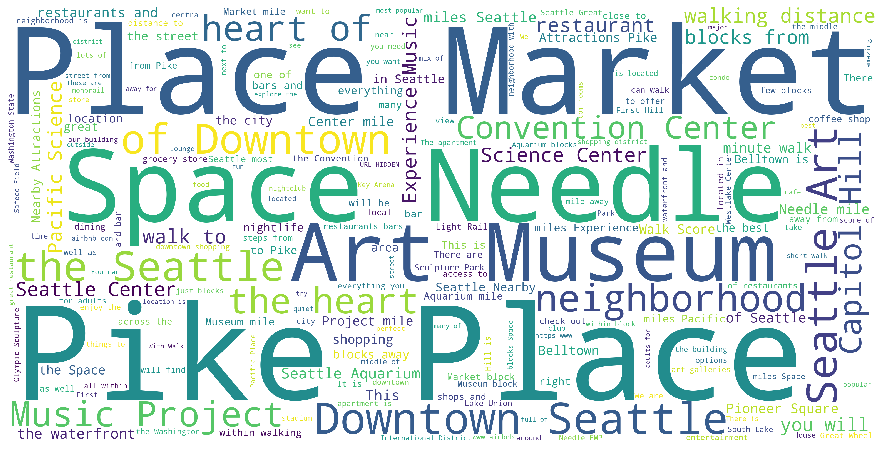

Magnolia


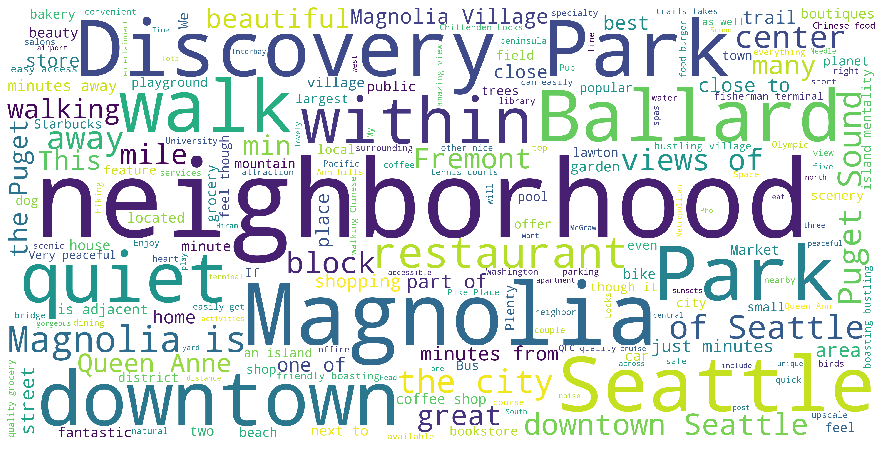

West Seattle


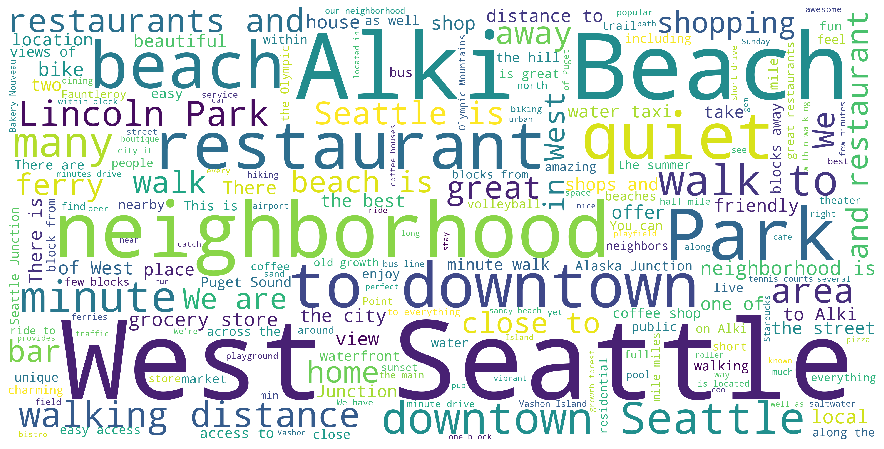

Interbay


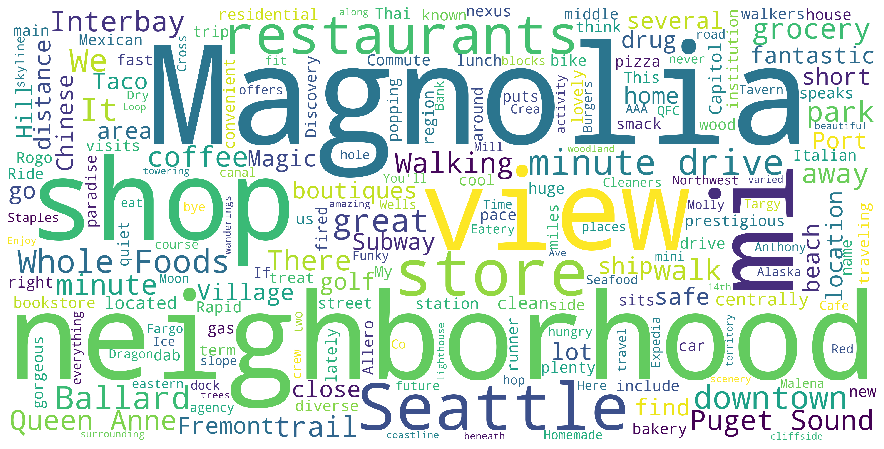

Beacon Hill


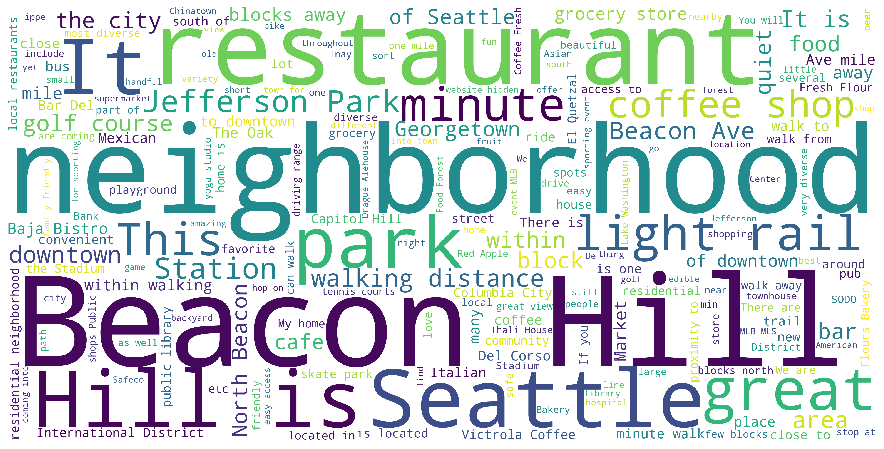

Rainier Valley


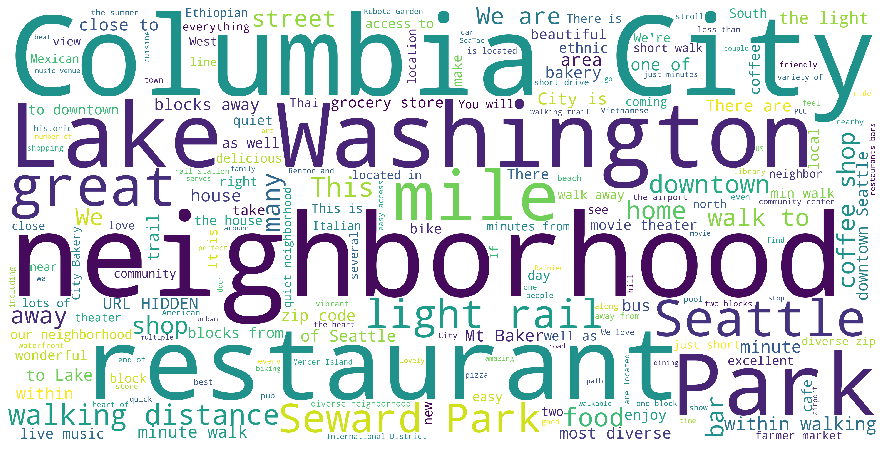

Delridge


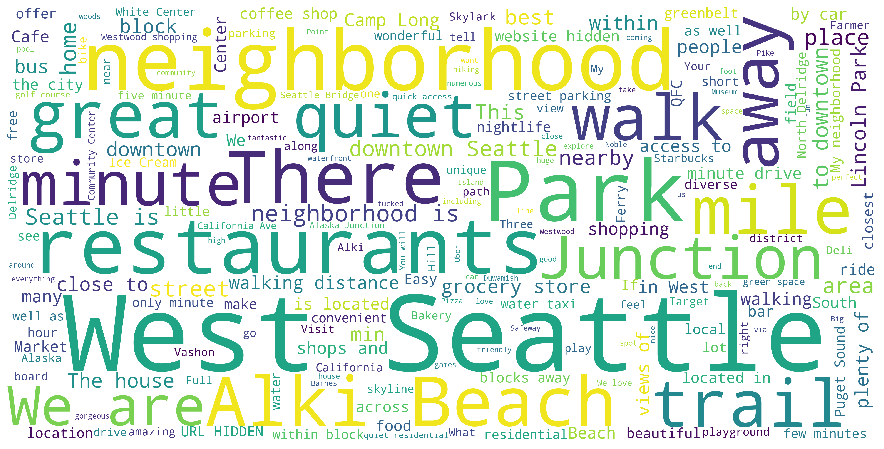

Seward Park


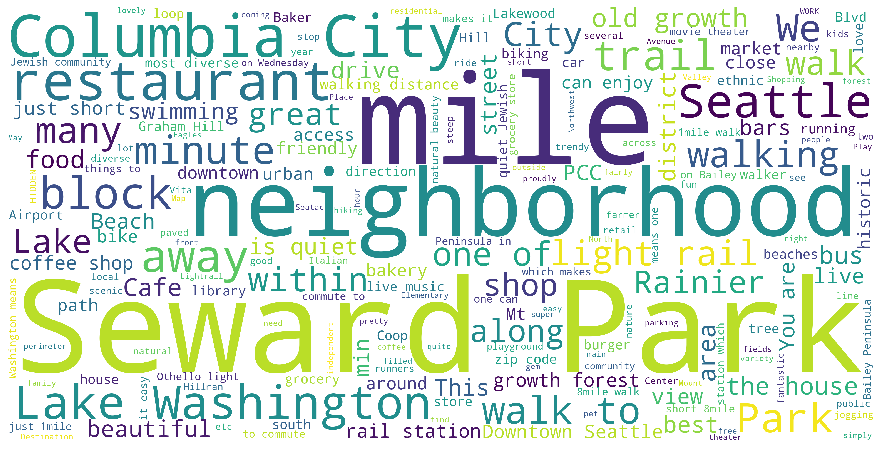

Northgate


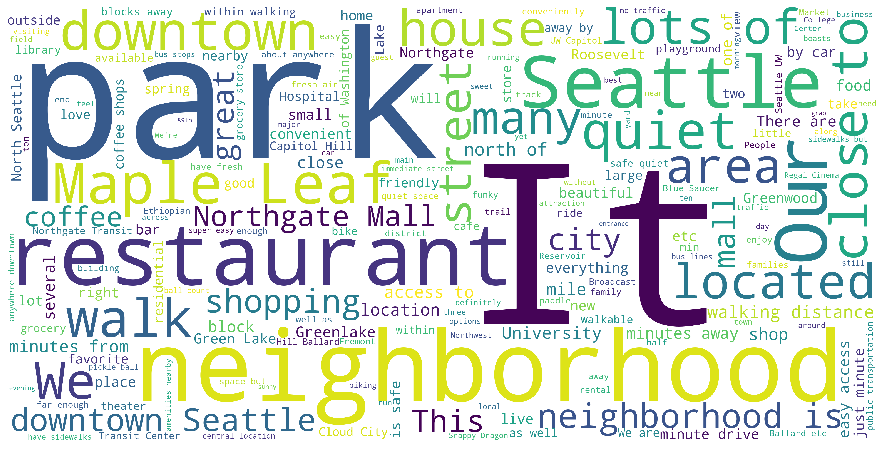

Capitol Hill


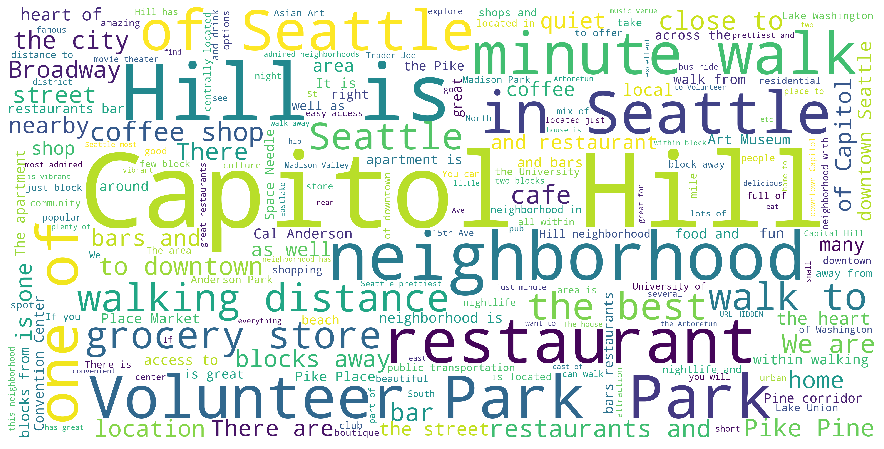

Lake City


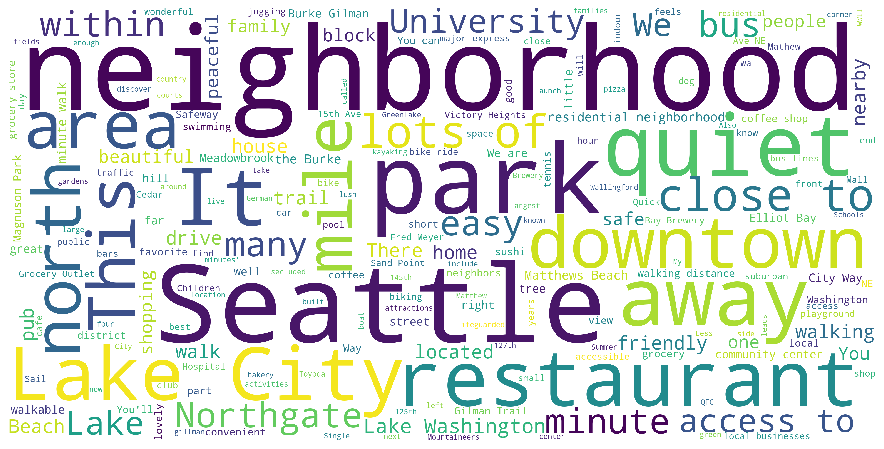

In [22]:
# Creating wordcloud to find out the vibe inside each neighbourhood in Seattle
listing_df2 = listing_df.copy()
listing_df2['neighborhood_overview'].replace(np.nan, "", inplace=True)
listing_df2['neighborhood_overview'] = listing_df2.groupby('neighbourhood_group_cleansed')['neighborhood_overview'].transform(lambda x: ','.join(x))

neighbourhood_group_cleansed = listing_df2['neighbourhood_group_cleansed'].unique().tolist()

for neighbourhood in neighbourhood_group_cleansed:
    print(neighbourhood)
    corpus = listing_df2[listing_df2['neighbourhood_group_cleansed'] == neighbourhood]
    corpus = corpus.reset_index().loc[0]['neighborhood_overview']
    name_wordcloud = WordCloud(stopwords = STOPWORDS, background_color = 'white',
                               height = 2000, width = 4000)
    name_wordcloud = name_wordcloud.generate(corpus)
    plt.figure(figsize = (16,8))
    plt.imshow(name_wordcloud)
    plt.axis('off')
#     plt.savefig('wordcloud '+neighbourhood.lower()+'.png', dpi=1000);
    plt.show();

##### Insight from the wordcloud
From neighbourhood description, we can extract information about what the host want to show to their potential user. I created word cloud that show the word and its size based on its frequency in the description. For example, there is renowned destination such as Seattle Center in Queen Anne, Alki Beach in Delridge, Lake Washington in Lake City neigbourhood, and so on. Here below are some information based on neighbourhood description:

- Ballard: Golder Garden, Ballard Locks
- Beacon Hill: Jefferson Park, light rail
- Capitol Hill: Pike Pine, park
- Cascade: South Lake, Lake Union
- Central Area: Lake Washington
- Delridge: Alki Beach
- Downtown: Space Needle
- Interbay: Magnolia
- Lake City: Lake Washington
- Magnolia: Discovery Park
- Northgate: Maple Leaf
- Other Neighbourhood: Green Lake
- Queen Anne: Seattle Center
- Rainier Valley: Columbia City
- Seward Park: Columbia City
- University District: Univercities
- West Seattle: Alki Beach

Please see the word cloud above to find other information about the neigbourhood that you interested to.

In [34]:
listing_df.duplicated(subset=['id']).sum()

0

In [23]:
# Processing True/False value
listing_df['host_is_superhost'].replace(['t', 'f'], [True, False], inplace=True)
listing_df['require_guest_phone_verification'].replace(['t', 'f'], [True, False], inplace=True)

In [24]:
# Processing date
listing_df['last_scraped'] = pd.to_datetime(listing_df['last_scraped'])
listing_df['host_since'] = pd.to_datetime(listing_df['host_since'])

In [25]:
# Processing currency data
process_currency(listing_df, 'price')
process_currency(listing_df, 'weekly_price')
process_currency(listing_df, 'monthly_price')
process_currency(listing_df, 'cleaning_fee')
process_currency(listing_df, 'extra_people')
process_currency(listing_df, 'security_deposit')

In [26]:
# Find how long host has been hosting room
listing_df['hosting_exp'] = listing_df['last_scraped'] - listing_df['host_since']
listing_df['hosting_exp'] = pd.to_numeric(listing_df['hosting_exp'])

In [27]:
# Defining variables
feature_vars = ['hosting_exp', 'bathrooms', 'bedrooms', 'cleaning_fee', 'guests_included',
                'review_scores_rating', 'number_of_reviews', 'minimum_nights', 
                'host_listings_count', 'accommodates', 'review_scores_accuracy',
                'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication',
                'review_scores_location', 'room_type', 'amenities', 'property_type', 
                'bed_type','neighbourhood_group_cleansed', 'host_is_superhost', 
                'require_guest_phone_verification', 'security_deposit']

target_vars = ['price']

num_vars = ['price', 'hosting_exp', 'bathrooms', 'bedrooms', 'cleaning_fee', 'guests_included',
            'review_scores_rating','minimum_nights', 'host_listings_count', 'accommodates']

In [40]:
listing_df[feature_vars].isna().sum()

hosting_exp                            0
bathrooms                             16
bedrooms                               6
cleaning_fee                        1030
guests_included                        0
review_scores_rating                 647
number_of_reviews                      0
minimum_nights                         0
host_listings_count                    2
accommodates                           0
review_scores_accuracy               658
review_scores_cleanliness            653
review_scores_checkin                658
review_scores_communication          651
review_scores_location               655
room_type                              0
amenities                              0
property_type                          1
bed_type                               0
neighbourhood_group_cleansed           0
host_is_superhost                      2
require_guest_phone_verification       0
security_deposit                    1952
dtype: int64

In [28]:
# We should dropping square_feet column from out feature because of its missing values
feature_vars = ['hosting_exp', 'bathrooms', 'bedrooms', 'cleaning_fee', 'guests_included',
                'review_scores_rating', 'number_of_reviews', 'minimum_nights', 
                'host_listings_count', 'accommodates', 'review_scores_accuracy',
                'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication',
                'review_scores_location', 'room_type', 'amenities', 'property_type', 
                'bed_type','neighbourhood_group_cleansed', 'host_is_superhost', 
                'require_guest_phone_verification', 'security_deposit']

target_vars = ['price']

num_vars = ['price', 'hosting_exp', 'bathrooms', 'bedrooms', 'cleaning_fee', 'guests_included',
            'review_scores_rating','minimum_nights', 'host_listings_count', 'accommodates']

In [42]:
# See whether there is missing value in our variables
listing_df[feature_vars].isna().sum()

hosting_exp                            0
bathrooms                             16
bedrooms                               6
cleaning_fee                        1030
guests_included                        0
review_scores_rating                 647
number_of_reviews                      0
minimum_nights                         0
host_listings_count                    2
accommodates                           0
review_scores_accuracy               658
review_scores_cleanliness            653
review_scores_checkin                658
review_scores_communication          651
review_scores_location               655
room_type                              0
amenities                              0
property_type                          1
bed_type                               0
neighbourhood_group_cleansed           0
host_is_superhost                      2
require_guest_phone_verification       0
security_deposit                    1952
dtype: int64

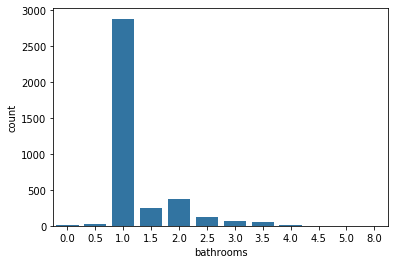

In [43]:
color = sb.color_palette()[0]
sb.countplot(data=listing_df, x='bathrooms', color=color);

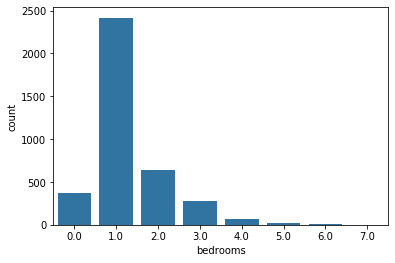

In [44]:
color = sb.color_palette()[0]
sb.countplot(data=listing_df, x='bedrooms', color=color);

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


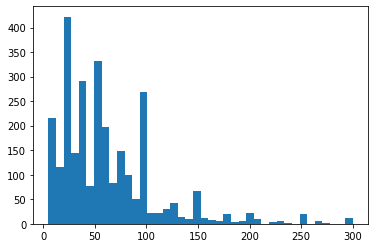

In [45]:
plt.hist(data=listing_df, x='cleaning_fee', bins=40);

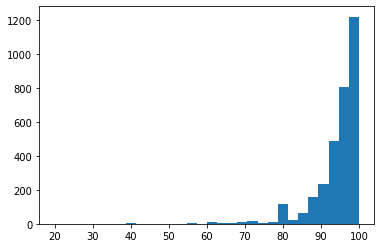

In [46]:
plt.hist(data=listing_df, x='review_scores_rating', bins=30);

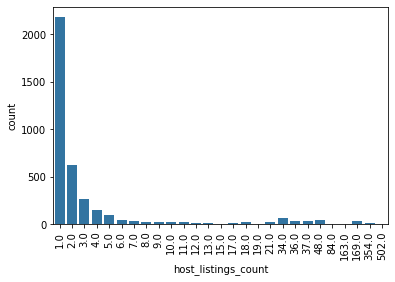

In [47]:
color = sb.color_palette()[0]
sb.countplot(data=listing_df, x='host_listings_count', color=color);
plt.xticks(rotation=90);

In [29]:
fill_mode_list= ['bathrooms', 'bedrooms', 'host_is_superhost', 'property_type']
fill_mean_list= ['cleaning_fee', 'review_scores_rating', 'host_listings_count', 
                 'review_scores_accuracy', 'review_scores_cleanliness', 
                 'review_scores_checkin', 'review_scores_communication', 
                 'review_scores_location', 'security_deposit']

fill_mode(listing_df, fill_mode_list)
fill_mean(listing_df, fill_mean_list)

In [49]:
listing_df[feature_vars].isna().sum()

hosting_exp                         0
bathrooms                           0
bedrooms                            0
cleaning_fee                        0
guests_included                     0
review_scores_rating                0
number_of_reviews                   0
minimum_nights                      0
host_listings_count                 0
accommodates                        0
review_scores_accuracy              0
review_scores_cleanliness           0
review_scores_checkin               0
review_scores_communication         0
review_scores_location              0
room_type                           0
amenities                           0
property_type                       0
bed_type                            0
neighbourhood_group_cleansed        0
host_is_superhost                   0
require_guest_phone_verification    0
security_deposit                    0
dtype: int64

In [50]:
listing_df[target_vars].isna().sum()

price    0
dtype: int64

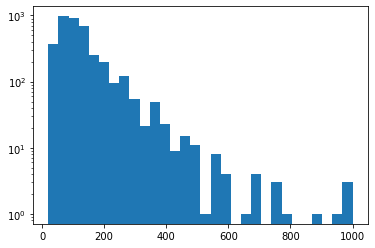

In [51]:
plt.hist(data=listing_df, x='price', bins=30);
plt.yscale('log');

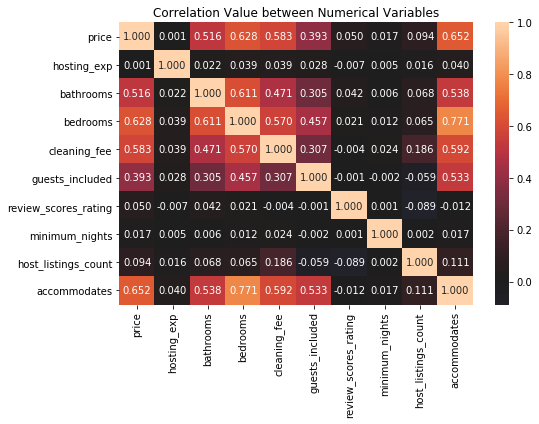

In [41]:
# Correlation plot of our numerical variables
plt.figure(figsize = [8, 6])
sb.heatmap(listing_df[num_vars].corr(), annot = True, fmt = '.3f',
            center = 0)
plt.title('Correlation Value between Numerical Variables')
plt.tight_layout()
# plt.savefig('Correlation Plot.png', dpi=1000);
plt.show();

Features such bathrooms, bedrooms, cleaning fee and accommodates are very correlated to room price. As we can see above, those features correlation values are above 0.5. Interestingly, we can also find that there is correlation between variable. Bedrooms and accommodates are very correlated with value above 0.75. Anyway, we should see their importance by using machine learning model.

In [31]:
# Creating dummy variables for amenities column
listing_df_edit = pd.concat([listing_df[feature_vars].copy(), 
                             listing_df[target_vars].copy()], axis=1)

listing_df_edit['amenities'] = listing_df_edit['amenities'].str.replace(r"[^a-zA-Z0-9/,\s]", "")

amenities_list = listing_df_edit['amenities'].str.split(',')

mlb = MultiLabelBinarizer()

amenities_df = pd.DataFrame(mlb.fit_transform(amenities_list),
                            columns=mlb.classes_, 
                            index=listing_df_edit.index).drop('', axis=1)
amenities_df_select = amenities_df.sum().sort_values(ascending=False)[:10].index.tolist()
amenities_df = amenities_df[amenities_df_select]

listing_df_edit = pd.concat([listing_df_edit.drop('amenities', axis=1), amenities_df], axis=1)

In [32]:
#turn categorical columns into dummy variables
cat_columns = list(listing_df_edit.select_dtypes(include=['object']).columns)

for column in cat_columns:
    listing_df_edit = pd.concat([listing_df_edit.drop(column, axis=1), pd.get_dummies(listing_df_edit[column], drop_first=True)], axis=1)
    
listing_df_edit.head()

,hosting_exp,bathrooms,bedrooms,cleaning_fee,guests_included,review_scores_rating,number_of_reviews,minimum_nights,host_listings_count,accommodates,...,Interbay,Lake City,Magnolia,Northgate,Other neighborhoods,Queen Anne,Rainier Valley,Seward Park,University District,West Seattle
0,138844800000000000,1.0,1.0,61.710904,2,95.000000,207,1,3.0,4,...,0,0,0,0,0,1,0,0,0,0
1,90460800000000000,1.0,1.0,40.000000,1,96.000000,43,2,6.0,4,...,0,0,0,0,0,1,0,0,0,0
2,49334400000000000,4.5,5.0,300.000000,10,97.000000,20,4,2.0,11,...,0,0,0,0,0,1,0,0,0,0
3,68169600000000000,1.0,0.0,61.710904,1,94.539262,0,1,1.0,3,...,0,0,0,0,0,1,0,0,0,0
4,129340800000000000,2.0,3.0,125.000000,6,92.000000,38,1,2.0,6,...,0,0,0,0,0,1,0,0,0,0


In [55]:
# Create pipeline for our machine learning model
pipeline = Pipeline([('clf', RandomForestRegressor(n_jobs=2))])
pipeline.get_params()

{'memory': None,
 'steps': [('clf',
   RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                         max_depth=None, max_features='auto', max_leaf_nodes=None,
                         max_samples=None, min_impurity_decrease=0.0,
                         min_impurity_split=None, min_samples_leaf=1,
                         min_samples_split=2, min_weight_fraction_leaf=0.0,
                         n_estimators=100, n_jobs=-1, oob_score=False,
                         random_state=None, verbose=0, warm_start=False))],
 'verbose': False,
 'clf': RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_s

In [56]:
# Setting parameters
parameters = {'clf__n_estimators': [150, 200, 250],
              'clf__min_samples_leaf': [1, 3, 4, 5, 7],
              'clf__min_samples_split': [2, 3, 4, 5, 7],
              }

cv = GridSearchCV(pipeline, parameters, verbose=60)

In [33]:
# Creating variables for our model and splitting the data
X = listing_df_edit.drop('price', axis=1)
y = listing_df_edit['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [57]:
# Training random forest model
cv.fit(X_train, y_train)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=150 
[CV]  clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=150, score=0.534, total=  14.8s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.7s remaining:    0.0s
[CV] clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=150 
[CV]  clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=150, score=0.488, total=   2.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   16.8s remaining:    0.0s
[CV] clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=150 
[CV]  clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=150, score=0.519, total=   2.6s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   19.4s remaining:    0.0s
[CV] clf__min_samples_leaf=1, clf__min_samples_split=2, clf

[CV]  clf__min_samples_leaf=1, clf__min_samples_split=4, clf__n_estimators=150, score=0.534, total=   3.0s
[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed:  2.1min remaining:    0.0s
[CV] clf__min_samples_leaf=1, clf__min_samples_split=4, clf__n_estimators=150 
[CV]  clf__min_samples_leaf=1, clf__min_samples_split=4, clf__n_estimators=150, score=0.491, total=   2.3s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:  2.1min remaining:    0.0s
[CV] clf__min_samples_leaf=1, clf__min_samples_split=4, clf__n_estimators=150 
[CV]  clf__min_samples_leaf=1, clf__min_samples_split=4, clf__n_estimators=150, score=0.532, total=   2.3s
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:  2.1min remaining:    0.0s
[CV] clf__min_samples_leaf=1, clf__min_samples_split=4, clf__n_estimators=150 
[CV]  clf__min_samples_leaf=1, clf__min_samples_split=4, clf__n_estimators=150, score=0.602, total=   2.5s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:  2.2min remaining:    0.0s
[CV] clf__min_s

[CV]  clf__min_samples_leaf=1, clf__min_samples_split=7, clf__n_estimators=150, score=0.545, total=   2.8s
[CV] clf__min_samples_leaf=1, clf__min_samples_split=7, clf__n_estimators=150 
[CV]  clf__min_samples_leaf=1, clf__min_samples_split=7, clf__n_estimators=150, score=0.614, total=   2.9s
[CV] clf__min_samples_leaf=1, clf__min_samples_split=7, clf__n_estimators=150 
[CV]  clf__min_samples_leaf=1, clf__min_samples_split=7, clf__n_estimators=150, score=0.685, total=   2.9s
[CV] clf__min_samples_leaf=1, clf__min_samples_split=7, clf__n_estimators=200 
[CV]  clf__min_samples_leaf=1, clf__min_samples_split=7, clf__n_estimators=200, score=0.539, total=   3.9s
[CV] clf__min_samples_leaf=1, clf__min_samples_split=7, clf__n_estimators=200 
[CV]  clf__min_samples_leaf=1, clf__min_samples_split=7, clf__n_estimators=200, score=0.475, total=   4.2s
[CV] clf__min_samples_leaf=1, clf__min_samples_split=7, clf__n_estimators=200 
[CV]  clf__min_samples_leaf=1, clf__min_samples_split=7, clf__n_estima

[CV]  clf__min_samples_leaf=3, clf__min_samples_split=4, clf__n_estimators=150, score=0.550, total=   2.1s
[CV] clf__min_samples_leaf=3, clf__min_samples_split=4, clf__n_estimators=150 
[CV]  clf__min_samples_leaf=3, clf__min_samples_split=4, clf__n_estimators=150, score=0.624, total=   2.2s
[CV] clf__min_samples_leaf=3, clf__min_samples_split=4, clf__n_estimators=150 
[CV]  clf__min_samples_leaf=3, clf__min_samples_split=4, clf__n_estimators=150, score=0.699, total=   2.4s
[CV] clf__min_samples_leaf=3, clf__min_samples_split=4, clf__n_estimators=200 
[CV]  clf__min_samples_leaf=3, clf__min_samples_split=4, clf__n_estimators=200, score=0.575, total=   2.7s
[CV] clf__min_samples_leaf=3, clf__min_samples_split=4, clf__n_estimators=200 
[CV]  clf__min_samples_leaf=3, clf__min_samples_split=4, clf__n_estimators=200, score=0.478, total=   2.9s
[CV] clf__min_samples_leaf=3, clf__min_samples_split=4, clf__n_estimators=200 
[CV]  clf__min_samples_leaf=3, clf__min_samples_split=4, clf__n_estima

[CV]  clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=150, score=0.550, total=   1.8s
[CV] clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=150 
[CV]  clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=150, score=0.620, total=   1.8s
[CV] clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=150 
[CV]  clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=150, score=0.699, total=   2.0s
[CV] clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=200, score=0.568, total=   2.6s
[CV] clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=200, score=0.482, total=   3.0s
[CV] clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=200 
[CV]  clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estima

[CV]  clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=150, score=0.557, total=   1.9s
[CV] clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=150 
[CV]  clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=150, score=0.620, total=   2.1s
[CV] clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=150 
[CV]  clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=150, score=0.701, total=   2.0s
[CV] clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=200 
[CV]  clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=200, score=0.571, total=   2.4s
[CV] clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=200 
[CV]  clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=200, score=0.480, total=   2.5s
[CV] clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=200 
[CV]  clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estima

[CV]  clf__min_samples_leaf=5, clf__min_samples_split=3, clf__n_estimators=150, score=0.555, total=   1.8s
[CV] clf__min_samples_leaf=5, clf__min_samples_split=3, clf__n_estimators=150 
[CV]  clf__min_samples_leaf=5, clf__min_samples_split=3, clf__n_estimators=150, score=0.618, total=   1.9s
[CV] clf__min_samples_leaf=5, clf__min_samples_split=3, clf__n_estimators=150 
[CV]  clf__min_samples_leaf=5, clf__min_samples_split=3, clf__n_estimators=150, score=0.691, total=   2.1s
[CV] clf__min_samples_leaf=5, clf__min_samples_split=3, clf__n_estimators=200 
[CV]  clf__min_samples_leaf=5, clf__min_samples_split=3, clf__n_estimators=200, score=0.569, total=   2.6s
[CV] clf__min_samples_leaf=5, clf__min_samples_split=3, clf__n_estimators=200 
[CV]  clf__min_samples_leaf=5, clf__min_samples_split=3, clf__n_estimators=200, score=0.480, total=   2.8s
[CV] clf__min_samples_leaf=5, clf__min_samples_split=3, clf__n_estimators=200 
[CV]  clf__min_samples_leaf=5, clf__min_samples_split=3, clf__n_estima

[CV]  clf__min_samples_leaf=5, clf__min_samples_split=7, clf__n_estimators=150, score=0.548, total=   1.8s
[CV] clf__min_samples_leaf=5, clf__min_samples_split=7, clf__n_estimators=150 
[CV]  clf__min_samples_leaf=5, clf__min_samples_split=7, clf__n_estimators=150, score=0.607, total=   1.8s
[CV] clf__min_samples_leaf=5, clf__min_samples_split=7, clf__n_estimators=150 
[CV]  clf__min_samples_leaf=5, clf__min_samples_split=7, clf__n_estimators=150, score=0.686, total=   1.9s
[CV] clf__min_samples_leaf=5, clf__min_samples_split=7, clf__n_estimators=200 
[CV]  clf__min_samples_leaf=5, clf__min_samples_split=7, clf__n_estimators=200, score=0.569, total=   3.1s
[CV] clf__min_samples_leaf=5, clf__min_samples_split=7, clf__n_estimators=200 
[CV]  clf__min_samples_leaf=5, clf__min_samples_split=7, clf__n_estimators=200, score=0.481, total=   2.5s
[CV] clf__min_samples_leaf=5, clf__min_samples_split=7, clf__n_estimators=200 
[CV]  clf__min_samples_leaf=5, clf__min_samples_split=7, clf__n_estima

[CV]  clf__min_samples_leaf=7, clf__min_samples_split=4, clf__n_estimators=150, score=0.550, total=   1.6s
[CV] clf__min_samples_leaf=7, clf__min_samples_split=4, clf__n_estimators=150 
[CV]  clf__min_samples_leaf=7, clf__min_samples_split=4, clf__n_estimators=150, score=0.613, total=   1.6s
[CV] clf__min_samples_leaf=7, clf__min_samples_split=4, clf__n_estimators=150 
[CV]  clf__min_samples_leaf=7, clf__min_samples_split=4, clf__n_estimators=150, score=0.688, total=   1.8s
[CV] clf__min_samples_leaf=7, clf__min_samples_split=4, clf__n_estimators=200 
[CV]  clf__min_samples_leaf=7, clf__min_samples_split=4, clf__n_estimators=200, score=0.568, total=   2.5s
[CV] clf__min_samples_leaf=7, clf__min_samples_split=4, clf__n_estimators=200 
[CV]  clf__min_samples_leaf=7, clf__min_samples_split=4, clf__n_estimators=200, score=0.480, total=   3.1s
[CV] clf__min_samples_leaf=7, clf__min_samples_split=4, clf__n_estimators=200 
[CV]  clf__min_samples_leaf=7, clf__min_samples_split=4, clf__n_estima

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('clf',
                                        RandomForestRegressor(bootstrap=True,
                                                              ccp_alpha=0.0,
                                                              criterion='mse',
                                                              max_depth=None,
                                                              max_features='auto',
                                                              max_leaf_nodes=None,
                                                              max_samples=None,
                                                              min_impurity_decrease=0.0,
                                                              min_impurity_split=None,
                                                              min_samples_leaf=1,
                                                     

In [58]:
# Printing out the best parameters for the model
cv.best_params_

{'clf__min_samples_leaf': 3,
 'clf__min_samples_split': 5,
 'clf__n_estimators': 150}

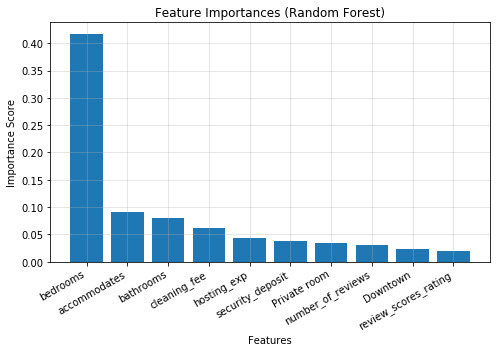

In [59]:
# Plotting features importance based from our model above
feature_importances = sorted(zip(X_train.columns, cv.best_estimator_
                                 .named_steps["clf"].feature_importances_))
feature_importances = pd.DataFrame(feature_importances,
                                   columns = ['feature', 'score'])
feature_importances = feature_importances.sort_values(by = ['score'],
                                                      ascending = False).reset_index().drop('index', axis=1)

plt.figure(figsize=(7,5))
plt.bar(feature_importances['feature'][:10], feature_importances['score'][:10])
plt.xticks(rotation=30, ha='right')
plt.grid(alpha=0.4);
plt.title('Feature Importances (Random Forest)')
plt.ylabel('Importance Score')
plt.xlabel('Features')
plt.tight_layout();
# plt.savefig('feature importances RF.png', dpi=1000);

Let's us find some insight from our model result above:
- Number of bedrooms, accommodates, and bathrooms are top features to predict how much do we need to pay for a night in out host. The more bedrooms, the higher the price.
- Type of room (shared or private) and host neighbourhood (e.g Downtown) will affect the price of a night sleeping.
- Renting price might depend on number of years since being a host and their number of review.

In [60]:
# Evaluate the model
evaluate_model(cv, X_train, X_test, y_train, y_test)

Train r2_score = 0.8335334072829084
Test r2_score = 0.6501487203245717


In [34]:
# We should dropping square_feet column from out feature because of its missing values
feature_vars = ['hosting_exp', 'bathrooms', 'bedrooms', 'cleaning_fee', 'guests_included']

target_vars = ['price']

num_vars = ['price', 'hosting_exp', 'bathrooms', 'bedrooms', 'cleaning_fee', 'guests_included',
            'review_scores_rating','minimum_nights', 'host_listings_count', 'accommodates']

In [35]:
X = listing_df_edit[feature_vars]
y = listing_df_edit['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [71]:
model = MLPRegressor(random_state=42, max_iter=600, hidden_layer_sizes=(30,))
model.fit(X_train, y_train)
evaluate_model(model, X_train, X_test, y_train, y_test)

Train r2_score = -0.7928622639741103
Test r2_score = -0.9431601178774578


In [67]:
# Create pipeline for our machine learning model
pipeline = Pipeline([('clf_ada', AdaBoostRegressor())])
pipeline.get_params()

{'memory': None,
 'steps': [('clf_ada',
   AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                     n_estimators=50, random_state=None))],
 'verbose': False,
 'clf_ada': AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                   n_estimators=50, random_state=None),
 'clf_ada__base_estimator': None,
 'clf_ada__learning_rate': 1.0,
 'clf_ada__loss': 'linear',
 'clf_ada__n_estimators': 50,
 'clf_ada__random_state': None}

In [68]:
# Setting parameters
parameters = {'clf_ada__n_estimators': [150, 200, 250],
              'clf_ada__loss': ['linear', 'square', 'exponential'],
              'clf_ada__learning_rate': [0.1, 0.5, 1.0],
              }

cv_ada = GridSearchCV(pipeline, parameters, verbose=60)

In [69]:
cv_ada.fit(X_train, y_train)
evaluate_model(cv_ada, X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] clf_ada__learning_rate=0.1, clf_ada__loss=linear, clf_ada__n_estimators=150 
[CV]  clf_ada__learning_rate=0.1, clf_ada__loss=linear, clf_ada__n_estimators=150, score=0.410, total=   0.5s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[CV] clf_ada__learning_rate=0.1, clf_ada__loss=linear, clf_ada__n_estimators=150 
[CV]  clf_ada__learning_rate=0.1, clf_ada__loss=linear, clf_ada__n_estimators=150, score=0.314, total=   0.8s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s
[CV] clf_ada__learning_rate=0.1, clf_ada__loss=linear, clf_ada__n_estimators=150 
[CV]  clf_ada__learning_rate=0.1, clf_ada__loss=linear, clf_ada__n_estimators=150, score=0.350, total=   1.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.1s remaining:    0.0s
[CV] clf_ada__learning_rate=0.1, clf_ada_

[CV]  clf_ada__learning_rate=0.1, clf_ada__loss=exponential, clf_ada__n_estimators=150, score=0.416, total=   0.8s
[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed:   29.4s remaining:    0.0s
[CV] clf_ada__learning_rate=0.1, clf_ada__loss=exponential, clf_ada__n_estimators=150 
[CV]  clf_ada__learning_rate=0.1, clf_ada__loss=exponential, clf_ada__n_estimators=150, score=0.330, total=   0.7s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:   30.1s remaining:    0.0s
[CV] clf_ada__learning_rate=0.1, clf_ada__loss=exponential, clf_ada__n_estimators=150 
[CV]  clf_ada__learning_rate=0.1, clf_ada__loss=exponential, clf_ada__n_estimators=150, score=0.352, total=   0.9s
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:   31.1s remaining:    0.0s
[CV] clf_ada__learning_rate=0.1, clf_ada__loss=exponential, clf_ada__n_estimators=150 
[CV]  clf_ada__learning_rate=0.1, clf_ada__loss=exponential, clf_ada__n_estimators=150, score=0.257, total=   0.9s
[Parallel(n_jobs=1)]: Done  34 out of  

[CV]  clf_ada__learning_rate=0.5, clf_ada__loss=square, clf_ada__n_estimators=150, score=-0.845, total=   0.7s
[CV] clf_ada__learning_rate=0.5, clf_ada__loss=square, clf_ada__n_estimators=150 
[CV]  clf_ada__learning_rate=0.5, clf_ada__loss=square, clf_ada__n_estimators=150, score=0.145, total=   0.7s
[CV] clf_ada__learning_rate=0.5, clf_ada__loss=square, clf_ada__n_estimators=150 
[CV]  clf_ada__learning_rate=0.5, clf_ada__loss=square, clf_ada__n_estimators=150, score=-0.384, total=   0.6s
[CV] clf_ada__learning_rate=0.5, clf_ada__loss=square, clf_ada__n_estimators=150 
[CV]  clf_ada__learning_rate=0.5, clf_ada__loss=square, clf_ada__n_estimators=150, score=0.236, total=   0.3s
[CV] clf_ada__learning_rate=0.5, clf_ada__loss=square, clf_ada__n_estimators=200 
[CV]  clf_ada__learning_rate=0.5, clf_ada__loss=square, clf_ada__n_estimators=200, score=0.223, total=   0.4s
[CV] clf_ada__learning_rate=0.5, clf_ada__loss=square, clf_ada__n_estimators=200 
[CV]  clf_ada__learning_rate=0.5, clf_

[CV]  clf_ada__learning_rate=1.0, clf_ada__loss=square, clf_ada__n_estimators=150, score=-0.050, total=   0.6s
[CV] clf_ada__learning_rate=1.0, clf_ada__loss=square, clf_ada__n_estimators=150 
[CV]  clf_ada__learning_rate=1.0, clf_ada__loss=square, clf_ada__n_estimators=150, score=-1.057, total=   0.7s
[CV] clf_ada__learning_rate=1.0, clf_ada__loss=square, clf_ada__n_estimators=150 
[CV]  clf_ada__learning_rate=1.0, clf_ada__loss=square, clf_ada__n_estimators=150, score=-0.011, total=   0.7s
[CV] clf_ada__learning_rate=1.0, clf_ada__loss=square, clf_ada__n_estimators=150 
[CV]  clf_ada__learning_rate=1.0, clf_ada__loss=square, clf_ada__n_estimators=150, score=-0.715, total=   0.7s
[CV] clf_ada__learning_rate=1.0, clf_ada__loss=square, clf_ada__n_estimators=150 
[CV]  clf_ada__learning_rate=1.0, clf_ada__loss=square, clf_ada__n_estimators=150, score=0.031, total=   0.6s
[CV] clf_ada__learning_rate=1.0, clf_ada__loss=square, clf_ada__n_estimators=200 
[CV]  clf_ada__learning_rate=1.0, cl

In [70]:
# Printing out the best parameters for the model
cv_ada.best_params_

{'clf_ada__learning_rate': 0.5,
 'clf_ada__loss': 'linear',
 'clf_ada__n_estimators': 200}

In [36]:
# Create pipeline for our machine learning model
pipeline1 = Pipeline([('clf', RandomForestRegressor(n_jobs=2))])
pipeline1.get_params()

{'memory': None,
 'steps': [('clf',
   RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                         max_depth=None, max_features='auto', max_leaf_nodes=None,
                         max_samples=None, min_impurity_decrease=0.0,
                         min_impurity_split=None, min_samples_leaf=1,
                         min_samples_split=2, min_weight_fraction_leaf=0.0,
                         n_estimators=100, n_jobs=2, oob_score=False,
                         random_state=None, verbose=0, warm_start=False))],
 'verbose': False,
 'clf': RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=2, oob_sco

In [37]:
# Setting parameters
parameters = {'clf__n_estimators': [50, 100],
              'clf__min_samples_leaf': [1, 3, 4, 5, 7],
              'clf__min_samples_split': [2, 3, 4, 5, 7],
              }

cv1 = GridSearchCV(pipeline1, parameters, verbose=60)

In [38]:
# Training random forest model
cv1.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=50 
[CV]  clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=50, score=0.488, total=   1.6s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[CV] clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=50 
[CV]  clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=50, score=0.404, total=   0.3s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s
[CV] clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=50 
[CV]  clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=50, score=0.520, total=   0.4s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.2s remaining:    0.0s
[CV] clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_es

[CV]  clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=50, score=0.424, total=   0.4s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:   18.2s remaining:    0.0s
[CV] clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=50 
[CV]  clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=50, score=0.525, total=   0.4s
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:   18.6s remaining:    0.0s
[CV] clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=50 
[CV]  clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=50, score=0.458, total=   0.5s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:   19.1s remaining:    0.0s
[CV] clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=50 
[CV]  clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=50, score=0.576, total=   0.4s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:   19.5s remaining:    0.0s
[CV] clf__min_samples_

[CV]  clf__min_samples_leaf=3, clf__min_samples_split=3, clf__n_estimators=50, score=0.606, total=   0.4s
[CV] clf__min_samples_leaf=3, clf__min_samples_split=3, clf__n_estimators=100 
[CV]  clf__min_samples_leaf=3, clf__min_samples_split=3, clf__n_estimators=100, score=0.518, total=   0.6s
[CV] clf__min_samples_leaf=3, clf__min_samples_split=3, clf__n_estimators=100 
[CV]  clf__min_samples_leaf=3, clf__min_samples_split=3, clf__n_estimators=100, score=0.445, total=   0.7s
[CV] clf__min_samples_leaf=3, clf__min_samples_split=3, clf__n_estimators=100 
[CV]  clf__min_samples_leaf=3, clf__min_samples_split=3, clf__n_estimators=100, score=0.527, total=   0.6s
[CV] clf__min_samples_leaf=3, clf__min_samples_split=3, clf__n_estimators=100 
[CV]  clf__min_samples_leaf=3, clf__min_samples_split=3, clf__n_estimators=100, score=0.512, total=   0.6s
[CV] clf__min_samples_leaf=3, clf__min_samples_split=3, clf__n_estimators=100 
[CV]  clf__min_samples_leaf=3, clf__min_samples_split=3, clf__n_estimat

[CV]  clf__min_samples_leaf=4, clf__min_samples_split=2, clf__n_estimators=100, score=0.610, total=   0.6s
[CV] clf__min_samples_leaf=4, clf__min_samples_split=3, clf__n_estimators=50 
[CV]  clf__min_samples_leaf=4, clf__min_samples_split=3, clf__n_estimators=50, score=0.521, total=   0.3s
[CV] clf__min_samples_leaf=4, clf__min_samples_split=3, clf__n_estimators=50 
[CV]  clf__min_samples_leaf=4, clf__min_samples_split=3, clf__n_estimators=50, score=0.449, total=   0.3s
[CV] clf__min_samples_leaf=4, clf__min_samples_split=3, clf__n_estimators=50 
[CV]  clf__min_samples_leaf=4, clf__min_samples_split=3, clf__n_estimators=50, score=0.531, total=   0.4s
[CV] clf__min_samples_leaf=4, clf__min_samples_split=3, clf__n_estimators=50 
[CV]  clf__min_samples_leaf=4, clf__min_samples_split=3, clf__n_estimators=50, score=0.523, total=   0.4s
[CV] clf__min_samples_leaf=4, clf__min_samples_split=3, clf__n_estimators=50 
[CV]  clf__min_samples_leaf=4, clf__min_samples_split=3, clf__n_estimators=50, 

[CV]  clf__min_samples_leaf=5, clf__min_samples_split=2, clf__n_estimators=50, score=0.608, total=   0.3s
[CV] clf__min_samples_leaf=5, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__min_samples_leaf=5, clf__min_samples_split=2, clf__n_estimators=100, score=0.530, total=   0.6s
[CV] clf__min_samples_leaf=5, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__min_samples_leaf=5, clf__min_samples_split=2, clf__n_estimators=100, score=0.458, total=   0.5s
[CV] clf__min_samples_leaf=5, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__min_samples_leaf=5, clf__min_samples_split=2, clf__n_estimators=100, score=0.534, total=   0.5s
[CV] clf__min_samples_leaf=5, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__min_samples_leaf=5, clf__min_samples_split=2, clf__n_estimators=100, score=0.524, total=   0.6s
[CV] clf__min_samples_leaf=5, clf__min_samples_split=2, clf__n_estimators=100 
[CV]  clf__min_samples_leaf=5, clf__min_samples_split=2, clf__n_estimat

[CV]  clf__min_samples_leaf=5, clf__min_samples_split=7, clf__n_estimators=100, score=0.612, total=   0.5s
[CV] clf__min_samples_leaf=7, clf__min_samples_split=2, clf__n_estimators=50 
[CV]  clf__min_samples_leaf=7, clf__min_samples_split=2, clf__n_estimators=50, score=0.533, total=   0.3s
[CV] clf__min_samples_leaf=7, clf__min_samples_split=2, clf__n_estimators=50 
[CV]  clf__min_samples_leaf=7, clf__min_samples_split=2, clf__n_estimators=50, score=0.460, total=   0.3s
[CV] clf__min_samples_leaf=7, clf__min_samples_split=2, clf__n_estimators=50 
[CV]  clf__min_samples_leaf=7, clf__min_samples_split=2, clf__n_estimators=50, score=0.529, total=   0.3s
[CV] clf__min_samples_leaf=7, clf__min_samples_split=2, clf__n_estimators=50 
[CV]  clf__min_samples_leaf=7, clf__min_samples_split=2, clf__n_estimators=50, score=0.543, total=   0.4s
[CV] clf__min_samples_leaf=7, clf__min_samples_split=2, clf__n_estimators=50 
[CV]  clf__min_samples_leaf=7, clf__min_samples_split=2, clf__n_estimators=50, 

[CV]  clf__min_samples_leaf=7, clf__min_samples_split=7, clf__n_estimators=50, score=0.603, total=   0.4s
[CV] clf__min_samples_leaf=7, clf__min_samples_split=7, clf__n_estimators=100 
[CV]  clf__min_samples_leaf=7, clf__min_samples_split=7, clf__n_estimators=100, score=0.527, total=   0.5s
[CV] clf__min_samples_leaf=7, clf__min_samples_split=7, clf__n_estimators=100 
[CV]  clf__min_samples_leaf=7, clf__min_samples_split=7, clf__n_estimators=100, score=0.454, total=   0.5s
[CV] clf__min_samples_leaf=7, clf__min_samples_split=7, clf__n_estimators=100 
[CV]  clf__min_samples_leaf=7, clf__min_samples_split=7, clf__n_estimators=100, score=0.525, total=   0.6s
[CV] clf__min_samples_leaf=7, clf__min_samples_split=7, clf__n_estimators=100 
[CV]  clf__min_samples_leaf=7, clf__min_samples_split=7, clf__n_estimators=100, score=0.534, total=   0.5s
[CV] clf__min_samples_leaf=7, clf__min_samples_split=7, clf__n_estimators=100 
[CV]  clf__min_samples_leaf=7, clf__min_samples_split=7, clf__n_estimat

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('clf',
                                        RandomForestRegressor(bootstrap=True,
                                                              ccp_alpha=0.0,
                                                              criterion='mse',
                                                              max_depth=None,
                                                              max_features='auto',
                                                              max_leaf_nodes=None,
                                                              max_samples=None,
                                                              min_impurity_decrease=0.0,
                                                              min_impurity_split=None,
                                                              min_samples_leaf=1,
                                                     

In [39]:
evaluate_model(cv1, X_train, X_test, y_train, y_test)

Train r2_score = 0.6578647236168398
Test r2_score = 0.5457839498912413


In [40]:
cv1.best_params_

{'clf__min_samples_leaf': 7,
 'clf__min_samples_split': 2,
 'clf__n_estimators': 50}